## Import

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# import utils from specific folder
# import sys
# sys.path.append(r'C:\Users\yftac\Documents\00_Project_Afeka\models')
import importlib
import Utils_models
importlib.reload(Utils_models)
from Utils_models import *

In [3]:
# Refresh Models_Classes module
import Models_Classes
importlib.reload(Models_Classes)

<module 'Models_Classes' from 'c:\\Users\\yftac\\Documents\\00_Project_Afeka\\models\\v2\\Models_Classes.py'>

## Load DataLoader 

In [4]:
importlib.reload(Models_Classes)
from Models_Classes import LoadCSV_to_Dataset

## Load DL models classes

### MLP baseline model

In [5]:
importlib.reload(Models_Classes)
from Models_Classes import MLPBaseline

### EncDec with Noise (PECnet inspired)

In [6]:
importlib.reload(Models_Classes)
from Models_Classes import EncDec_Noise # One latent space for all features

In [7]:
importlib.reload(Models_Classes)
from Models_Classes import EncDec_Noise_1  # Seperate latent space for zones and ttc

In [8]:
# original model parameters: lr=1e-3 ,input_dim=2 ,latent_dim=16 ,hidden_dim=64

### LSTM

In [9]:
importlib.reload(Models_Classes)
from Models_Classes import LSTM

### LSTM with Encoding Pooling

In [10]:
importlib.reload(Models_Classes)
from Models_Classes import LSTM_Pooling

### Transformer

In [11]:
importlib.reload(Models_Classes)
from Models_Classes import TrajTransformer

## def train function

In [12]:
### Training Penalty Criterion Class
class ThresholdMSELoss(nn.Module):
    def __init__(self, threshold, penalty_factor):
        super().__init__()
        self.threshold = threshold
        self.penalty_factor = penalty_factor
        self.mse = nn.MSELoss(reduction='none')
        # self.mse = nn.MSELoss(reduction='mean') # options: mean, sum, none

    def forward(self, pred, target):
        loss = self.mse(pred, target)
        mask = (torch.abs(pred - target) > self.threshold).float() # Creates a mask tensor: 
                                                                   # 1 where the absolute error is 
                                                                   # greater than the threshold, 0 otherwise.
        loss = loss * (1 + mask * (self.penalty_factor - 1))       # if mask=0 loss is unchanged, 
                                                                   # if mask=1 loss multiplied by penalty_factor
        return loss.mean()

In [13]:
def train_model(model, dataloader, epochs, lr, device, penalty_spec):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # choose criterion: nn.MSE or nn.MSE+Penalty
    if penalty_spec['penalty_active']:
        criterion = ThresholdMSELoss(threshold=penalty_spec['penalty_threshold'], 
                                    penalty_factor=penalty_spec['penalty_factor'])
    else:
        criterion = nn.MSELoss()
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        # for obs, fut in dataloader:
        for obs, fut in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit=" training_batch"):
            obs = obs.to(device)
            fut = fut.to(device)
            optimizer.zero_grad()
            pred = model(obs)
            loss = criterion(pred, fut) 
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return model, loss_history

## load data and device

In [14]:
features_xy_cords = ['xCenter', 'yCenter']  # x and y coordinates
features_zones =    ['zone_zebra', 'zone_1', 'zone_2', 'zone_3']
features_ttc_123 =      ['ttc_1', 'ttc_2', 'ttc_3']
features_ttc_456 =      ['ttc_4', 'ttc_5', 'ttc_6']
features_ttc_789 =      ['ttc_7', 'ttc_8', 'ttc_9']
features_ttc = features_ttc_123 + features_ttc_456 + features_ttc_789

input_features = features_xy_cords   + features_zones  + features_ttc    # input all features
# input_features = features_xy_cords                                       # input only xy

output_features = features_xy_cords                                     # out
# dimensions
input_dim = len(input_features)     # 2 + 4 + 9 = 15
output_dim = len(output_features)    # 2

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = r'C:\Users\yftac\Documents\00_Project_Afeka\ttc_calculation\13_data_tcc_flattened'

obs_input_len=8        # 8 history
fut_output_len=12       # 12 horizon
batch_size=64

dataset = LoadCSV_to_Dataset(folder_path, obs_input_len, fut_output_len, 
                             input_features, output_features)   # loads csv's into samples

# split for train-test
train_size = int(0.8 * len(dataset)) # split_percentage = 0.8
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                           generator=torch.Generator().manual_seed(42))
# Create dataloaders 
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False) # puts the samples into batches for training
test_dataloader = DataLoader(test_dataset, batch_size  , shuffle=False)

### print sizes of batch, dataset, dataloader

In [16]:
print("---------- dataset - the data loaded sequences samples:  ----------")
print("dataset length (number of samples):                                              ", len(dataset))
print()
obs, fut = dataset[0]
x=dataset[0]
print('for example sample=dataset[0]: \n', x)
print("Single sample, 'obs' shape [length observation, num features]:                   ", obs.shape)
print("Single sample  'fut' shape [length future\prediction, num features]:             ", fut.shape)
print()
# Show the batch size and shape from the dataloader
print("---------- dataloader - sequences arranged in batches (shuffeled\ not-shuffeled): ----------")
batch = next(iter(train_dataloader))
obs_batch, fut_batch = batch
print("Batch obs shape [num samples in batch, length observation, num features]:        ", obs_batch.shape)
print("Batch fut shape [num samples in batch, length future\prediction, num features]:  ", fut_batch.shape)
print()
print("---------- train-test split: ----------")
print("Train number of batches:                                                         ", len(train_dataloader))
print("Test number of batches:                                                          ", len(test_dataloader))

---------- dataset - the data loaded sequences samples:  ----------
dataset length (number of samples):                                               295473

for example sample=dataset[0]: 
 (tensor([[  32.1330,  -19.0826,    0.0000,    0.0000,    0.0000,    0.0000,
         1111.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000],
        [  32.1145,  -19.3861,    0.0000,    0.0000,    0.0000,    0.0000,
         1111.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000],
        [  32.0876,  -19.6866,    0.0000,    0.0000,    0.0000,    0.0000,
         1111.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000],
        [  32.0494,  -19.9639,    0.0000,    0.0000,    0.0000,    0.0000,
         1111.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000],
        [  32.0019,  -20.2268,    0.

## Initialize models

In [30]:
obs_len  = obs_input_len   # 8
pred_len = fut_output_len # 12
input_dim = input_dim # 2/6/15
hidden_dim=64
lstm_layers=3

model_MLPBaseline =     MLPBaseline(obs_len, pred_len, input_dim, output_dim, hidden_dim=64)

model_EncDec_Noise =    EncDec_Noise(obs_len, pred_len, input_dim, output_dim, 
                                    latent_dim=16, hidden_dim=hidden_dim)

model_EncDec_Noise_1 =  EncDec_Noise_1(obs_len, pred_len, input_dim, output_dim,
                                        hidden_dim,
                                        zone_dim=len(features_zones), 
                                        ttc_dim=len(features_ttc),
                                        zone_latent_dim=16, 
                                        ttc_latent_dim=32)

model_LSTM =            LSTM(obs_len, pred_len, input_dim, output_dim, hidden_dim, lstm_layers)

model_LSTM_Pooling =    LSTM_Pooling(obs_len, pred_len, input_dim, output_dim,
                                    lstm_layers,
                                    zone_dim=len(features_zones), 
                                    ttc_dim=len(features_ttc),
                                    scene_pool_dim=2,  #16
                                    social_pool_dim=2, #32
                                    lstm_hidden_dim=128
                                    )

model_TrajTransformer = TrajTransformer(obs_len, pred_len, input_dim, output_dim,
                                        d_model=64, nhead=4, num_layers=2, 
                                        dim_feedforward=128, dropout=0.1)

### print schemes

In [31]:
# model_MLPBaseline
# model_EncDec_Noise
# model_EncDec_Noise_1
# model_LSTM
model_LSTM_Pooling
# model_TrajTransformer

LSTM_Pooling(
  (scene_pool): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
    (3): ReLU()
  )
  (social_pool): Sequential(
    (0): Linear(in_features=72, out_features=144, bias=True)
    (1): ReLU()
    (2): Linear(in_features=144, out_features=2, bias=True)
    (3): ReLU()
  )
  (combined_encoder): Sequential(
    (0): Linear(in_features=104, out_features=208, bias=True)
    (1): ReLU()
    (2): Linear(in_features=208, out_features=4, bias=True)
    (3): ReLU()
  )
  (xy_encoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
  )
  (lstm): LSTM(6, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

### Only run this cell to load model from a .pth file

In [ ]:
# file_name = "EncDec_Noise_xy_zone_ttc_epoch_500_h-h_8-12_penalty_false.pth"
# model_EncDec_Noise, checkpoint_EncDec_Noise = load_model(file_name, 
#                                                              EncDec_Noise, device)

# file_name = "EncDec_Noise_1_xy_zone_ttc_epoch_50_h-h_8-12.pth"
# model_EncDec_Noise_1, checkpoint_EncDec_Noise_1 = load_model(file_name, 
#                                                              EncDec_Noise_1, device)

# file_name = "LSTM_xy_zone_ttc_epoch_20_h-h_8-12.pth"
# file_name = "LSTM_xy_epoch_20_h-h_8-12_pt1_pf1.2.pth"
# model_LSTM, checkpoint_LSTM = load_model(file_name, LSTM, device)

# file_name_LSTM_Pooling = "LSTM_Pooling_xy_zone_ttc_epoch_20_h-h_8-12_pt1_pf1.2.pth"
# # file_name_LSTM_Pooling = "LSTM_Pooling_xy_zone_ttc_epoch_40_h-h_8-12_penalty_false.pth"
# model_LSTM_Pooling, checkpoint_LSTM_Pooling = load_model(file_name_LSTM_Pooling, 
#                                                          LSTM_Pooling, device)

# file_name = "test_TrajTransformer.pth"
# model_TrajTransformer, checkpoint_TrajTransformer = load_model(file_name, 
                                                        #  TrajTransformer, device)

Loaded and switch to eval: LSTM_xy_epoch_20_h-h_8-12_pt1_pf1.2.pth


c:\Users\yftac\Documents\00_Project_Afeka\models\v2\Utils_models.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_name, map_location=device)

In [20]:
# checkpoint_LSTM_Pooling['penalty_spec']
# len(checkpoint_EncDec_Noise['loss_history'])
# loss_history = checkpoint_LSTM_Pooling['loss_history']
loss_history = checkpoint_LSTM['loss_history']

# lr=checkpoint_LSTM_Pooling['lr']
# loss_history = checkpoint_LSTM['loss_history']
# len(checkpoint_LSTM['loss_history'])
len(loss_history)

20

## Train

In [32]:
loss_history = []

In [33]:
epochs=20

lr=1e-3
# penalty specifications: active, values of threshold and factor

penalty_spec = {'penalty_active': True, 'penalty_threshold':1, 'penalty_factor':1.3}

# penalty_spec = checkpoint_LSTM_Pooling['penalty_spec']

In [34]:
# Train
start=time.time()

# model_MLPBaseline, loss_history_current = train_model(model_MLPBaseline, train_dataloader,
#                                                epochs, lr, device=device, penalty_spec=penalty_spec)

# model_EncDec_Noise, loss_history_current = train_model(model_EncDec_Noise, train_dataloader, 
#                                            epochs, lr, device=device, penalty_spec=penalty_spec)

# model_EncDec_Noise_1, loss_history_current = train_model(model_EncDec_Noise_1, train_dataloader, 
#                                            epochs, lr, device=device,   penalty_spec=penalty_spec)

# model_LSTM, loss_history_current = train_model(model_LSTM, train_dataloader,
#                                                epochs, lr, device=device, penalty_spec=penalty_spec)

model_LSTM_Pooling, loss_history_current = train_model(model_LSTM_Pooling, train_dataloader,
                                                       epochs, lr, device=device, penalty_spec=penalty_spec)

# model_TrajTransformer, loss_history_current = train_model(model_TrajTransformer, train_dataloader,
#                                                        epochs, lr, device=device, penalty_spec=penalty_spec)

print(f"Training time: {((time.time() - start)/60):.2f} minutes")
# store the loss history
if 'loss_history' in locals():
    loss_history.extend(loss_history_current)
else:
    loss_history = loss_history_current

Epoch 1/20: 100%|██████████| 3694/3694 [02:01<00:00, 30.44 training_batch/s]


Epoch 1/20, Loss: 240.9832


Epoch 2/20: 100%|██████████| 3694/3694 [02:03<00:00, 29.83 training_batch/s]


Epoch 2/20, Loss: 3.0235


Epoch 3/20: 100%|██████████| 3694/3694 [02:05<00:00, 29.52 training_batch/s]


Epoch 3/20, Loss: 0.7791


Epoch 4/20: 100%|██████████| 3694/3694 [02:04<00:00, 29.75 training_batch/s]


Epoch 4/20, Loss: 0.5097


Epoch 5/20: 100%|██████████| 3694/3694 [02:03<00:00, 30.01 training_batch/s]


Epoch 5/20, Loss: 0.3937


Epoch 6/20: 100%|██████████| 3694/3694 [01:58<00:00, 31.20 training_batch/s]


Epoch 6/20, Loss: 0.3269


Epoch 7/20: 100%|██████████| 3694/3694 [01:55<00:00, 31.85 training_batch/s]


Epoch 7/20, Loss: 0.2805


Epoch 8/20: 100%|██████████| 3694/3694 [01:57<00:00, 31.42 training_batch/s]


Epoch 8/20, Loss: 0.2514


Epoch 9/20: 100%|██████████| 3694/3694 [02:01<00:00, 30.31 training_batch/s]


Epoch 9/20, Loss: 0.2247


Epoch 10/20: 100%|██████████| 3694/3694 [01:59<00:00, 30.99 training_batch/s]


Epoch 10/20, Loss: 0.2025


Epoch 11/20: 100%|██████████| 3694/3694 [01:58<00:00, 31.27 training_batch/s]


Epoch 11/20, Loss: 0.1815


Epoch 12/20: 100%|██████████| 3694/3694 [01:58<00:00, 31.14 training_batch/s]


Epoch 12/20, Loss: 0.1630


Epoch 13/20: 100%|██████████| 3694/3694 [01:57<00:00, 31.49 training_batch/s]


Epoch 13/20, Loss: 0.1471


Epoch 14/20: 100%|██████████| 3694/3694 [01:55<00:00, 32.01 training_batch/s]


Epoch 14/20, Loss: 0.1329


Epoch 15/20: 100%|██████████| 3694/3694 [01:56<00:00, 31.78 training_batch/s]


Epoch 15/20, Loss: 0.1216


Epoch 16/20: 100%|██████████| 3694/3694 [01:57<00:00, 31.56 training_batch/s]


Epoch 16/20, Loss: 0.1096


Epoch 17/20: 100%|██████████| 3694/3694 [01:52<00:00, 32.71 training_batch/s]


Epoch 17/20, Loss: 0.0983


Epoch 18/20: 100%|██████████| 3694/3694 [01:51<00:00, 33.09 training_batch/s]


Epoch 18/20, Loss: 0.0888


Epoch 19/20: 100%|██████████| 3694/3694 [01:51<00:00, 33.11 training_batch/s]


Epoch 19/20, Loss: 0.0817


Epoch 20/20: 100%|██████████| 3694/3694 [01:52<00:00, 32.87 training_batch/s]

Epoch 20/20, Loss: 0.0763
Training time: 39.37 minutes


In [22]:
len(loss_history)

20

### save to .pth

In [23]:
print(input_features)

['xCenter', 'yCenter', 'zone_zebra', 'zone_1', 'zone_2', 'zone_3', 'ttc_1', 'ttc_2', 'ttc_3', 'ttc_4', 'ttc_5', 'ttc_6', 'ttc_7', 'ttc_8', 'ttc_9']


In [24]:
### Save trained model state_dict and hyperparameters to .pth file ###

###    → → → → → → All Features ← ← ← ← ← ←    ###

# model_name_str = "EncDec_Noise_xy_zone_ttc_" + "epoch_" + str(len(loss_history)) + "_h-h_" + str(obs_input_len) + "-" + str(fut_output_len) + "_penalty_false"
# file_name_to_save = model_name_str + ".pth"
# checkpoint_EncDec_Noise=save_model(model_EncDec_Noise, model_name_str, file_name_to_save, 
#                                     loss_history, lr, epochs, batch_size, penalty_spec)

# model_name_str = "EncDec_Noise_xy_" + "epoch_" + str(len(loss_history)) + "_h-h_" + str(obs_input_len) + "-" + str(fut_output_len) + "_penalty_false"
# file_name_to_save = model_name_str + ".pth"
# checkpoint_EncDec_Noise=save_model(model_EncDec_Noise, model_name_str, file_name_to_save, 
#                                     loss_history, lr, epochs, batch_size, penalty_spec)

# model_name_str = "LSTM_xy_zone_ttc_"+"epoch_"+ str(len(loss_history))+"_h-h_"+str(obs_input_len)+"-"+str(fut_output_len) + "_penalty_false"
# file_name_to_save = model_name_str + ".pth"
# checkpoint__LSTM=save_model(model_LSTM, model_name_str, file_name_to_save, 
#                                     loss_history, lr, epochs, batch_size, penalty_spec)


model_name_str = "LSTM_Pooling_xy_zone_ttc_"+"epoch_"+ str(len(loss_history))+"_h-h_"+str(obs_input_len)+"-"+str(fut_output_len)+"_pt"+str(penalty_spec['penalty_threshold'])+"_pf"+str(penalty_spec['penalty_factor'])
# model_name_str = 'test_LSTM_Pooling'
file_name_to_save = model_name_str + ".pth"
checkpoint_LSTM_Pooling=save_model(model_LSTM_Pooling, model_name_str, file_name_to_save, 
                                    loss_history, lr, epochs, batch_size, penalty_spec)

# model_name_str = 'test_TrajTransformer'
# model_name_str = "TrajTransformer_xy_zone_ttc"+"_epoch_"+str(epochs)+"_h-h_"+str(obs_input_len)+"-"+str(fut_output_len)
# file_name_to_save = model_name_str + ".pth"
# checkpoint_TrajTransformer=save_model(model_TrajTransformer, model_name_str, file_name_to_save, 
#                                     loss_history, lr, epochs, batch_size, penalty_spec)


###    → → → → → → XY feature only  ← ← ← ← ← ←    ###

# model_name_str = "EncDec_Noise_xy_"+"epoch_"+ str(len(loss_history))+"_h-h_"+str(obs_input_len)+"-"+str(fut_output_len)
# file_name_to_save = model_name_str + ".pth"
# checkpoint_EncDec_Noise=save_model(model_EncDec_Noise, model_name_str, file_name_to_save, 
#                                     loss_history, lr, epochs, batch_size, penalty_spec)

# model_name_str = "LSTM_xy_"+"epoch_"+ str(len(loss_history))+"_h-h_"+str(obs_input_len)+"-"+str(fut_output_len)+"_pt"+str(penalty_spec['penalty_threshold'])+"_pf"+str(penalty_spec['penalty_factor'])
# file_name_to_save = model_name_str + ".pth"
# checkpoint__LSTM=save_model(model_LSTM, model_name_str, file_name_to_save, 
#                                     loss_history, lr, epochs, batch_size, penalty_spec)


file saved:  LSTM_Pooling_xy_zone_ttc_epoch_20_h-h_8-12_pt1_pf1.1.pth


### Evaluate with ADE and FDE and Plot loss

In [22]:
### load loss history for plotting of saved model ###

# loss_history = checkpoint_EncDec_Noise_1['loss_history']
# loss_history = checkpoint_LSTM['loss_history']
# loss_history = checkpoint_LSTM_Pooling['loss_history']
# loss_history = checkpoint_TrajTransformer['loss_history']

In [25]:
filter_threshold_for_extremes = 1

In [28]:
# eval_test, eval_test_extremes = evaluate_model(model_MLPBaseline, test_dataloader, device, filter_threshold_for_extremes)

# eval_test, eval_test_extremes = evaluate_model(model_EncDec_Noise, test_dataloader, device, filter_threshold_for_extremes)

# eval_test, eval_test_extremes = evaluate_model(model_EncDec_Noise_1, test_dataloader, device, filter_threshold_for_extremes)

# eval_test, eval_test_extremes = evaluate_model(model_LSTM, test_dataloader, device, filter_threshold_for_extremes)

eval_test, eval_test_extremes = evaluate_model(model_LSTM_Pooling, test_dataloader, device, filter_threshold_for_extremes)

# eval_test, eval_test_extremes = evaluate_model(model_TrajTransformer, test_dataloader, device, filter_threshold_for_extremes)

In [29]:
print('Metrics:')
print(f"    Avg. ADE/FDE: {eval_test['mean_ade']:.3f}/{eval_test['mean_fde']:.3f}")
print('\nMetrics Extremes:')
print("    Total samples ADE/FDE:                       ", len(eval_test['ade_list']),"/", len(eval_test['fde_list']))
print(f"    Number of ADE/FDE values greater than {filter_threshold_for_extremes}:      {eval_test_extremes['counts_greater_ade']}/{eval_test_extremes['counts_greater_fde']}")
print(f"    Percentage of ADE/FDE values greater than {filter_threshold_for_extremes}:  {eval_test_extremes['counts_greater_ade'] / len(eval_test['ade_list']) * 100:.3f}/{eval_test_extremes['counts_greater_fde'] / len(eval_test['fde_list']) * 100:.3f} %")
print(f"    Mean ADE/FDE values greater than {filter_threshold_for_extremes}:           {eval_test_extremes['mean_ade']:.3f}/{eval_test_extremes['mean_fde']:.3f}")
print(f"    Median ADE/FDE values greater than {filter_threshold_for_extremes}:         {eval_test_extremes['median_ade']:.3f}/{eval_test_extremes['median_fde']:.3f}")

Metrics:
    Avg. ADE/FDE: 0.282/0.711

Metrics Extremes:
    Total samples ADE/FDE:                        59095 / 59095
    Number of ADE/FDE values greater than 1:      654/11965
    Percentage of ADE/FDE values greater than 1:  1.107/20.247 %
    Mean ADE/FDE values greater than 1:           1.263/1.653
    Median ADE/FDE values greater than 1:         1.185/1.389


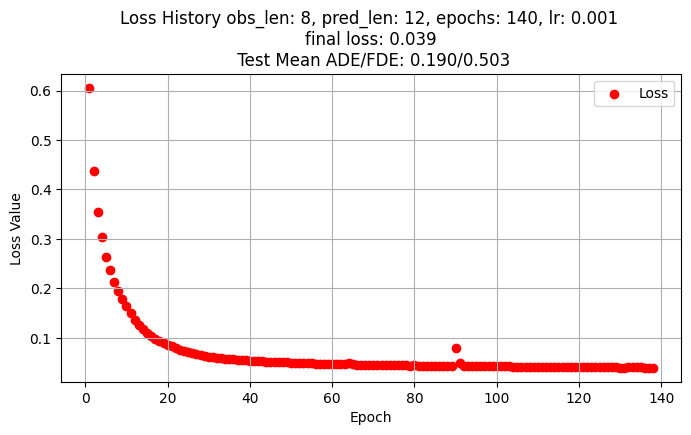

In [77]:
plot_title_detailes =(f"obs_len: {obs_len}, pred_len: {pred_len}, epochs: {len(loss_history)}, lr: {lr} \nfinal loss: {loss_history[-1]:.3f}\n Test Mean ADE/FDE: {eval_test['mean_ade']:.3f}/{eval_test['mean_fde']:.3f}")
# plot_loss_history(loss_history, len(loss_history), plot_title_detailes)
start_index = 2
plot_loss_history(loss_history[start_index:], len(loss_history[start_index:]), plot_title_detailes) #since first loss is very large ignore it for graph

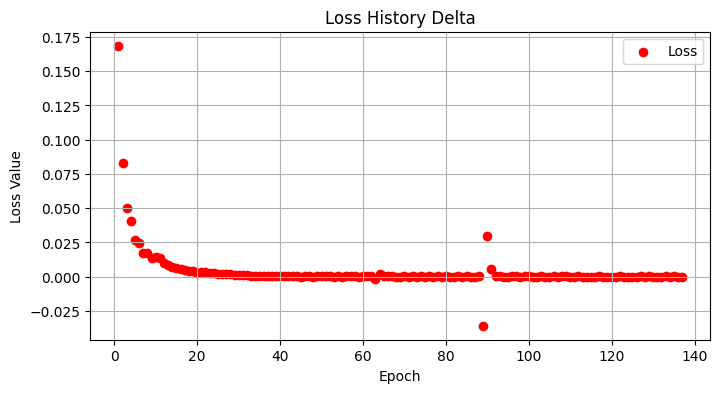

Last loss delta value: -3.6009149671278884e-05


In [79]:
# loss Delta
loss_delta = [loss_history[i - 1]-loss_history[i] for i in range(1, len(loss_history))]
start_index = 2
plot_loss_history(loss_delta[start_index:], len(loss_delta[start_index:]), 'Delta')
print("Last loss delta value:", loss_delta[-1])

## Plot  Seq Samples

In [4]:
# Plot samples from dataloader

# plot_model_predictions_sample_from_dataloader(model_EncDec_Noise, test_dataloader, device, num_samples=9)
plot_model_predictions_sample_from_dataloader(model_LSTM, test_dataloader, device, num_samples=9)

NameError: name 'model_LSTM' is not defined

## plot on maps

In [57]:
# Specify the directory to load files from
directory = r'C:\Users\yftac\Documents\00_Project_Afeka\ttc_calculation\13_data_tcc_flattened'
file_name_list = os.listdir(directory)
recordingId_list=load_recordingId_list(directory)
image_paths=load_background_images_path(recordingId_list)
root_dir=r'C:\Users\yftac\Documents\00_Project_Afeka\models'
dfs = load_dfs(file_name_list, root_dir, directory)

image_path_recordingId_18=r'C:\Users\yftac\Documents\00_Project_Afeka\inD\drone-dataset-tools-master\data\18_background.png'

scale_down_factor = 12
orthoPxToMeter = 0.00814636091724502

In [30]:
SEQ_LEN= 8  # Length of the sequence to plot
PRED_LEN= 12  # Length of the prediction to plot

In [31]:
def predict_from_dataloader(model, dataloader, device):
    """     model predict of data in dataloader.
    dataloader is the sequences made by dataset from csv.
    dataloader is the input in the form of a torch DataLoader tensor
    return lists instead of tensors     """
    model.eval()
    obs_list, fut_list, pred_list = [], [], []
    i=0
    with torch.no_grad():
        for obs, fut in dataloader:
            obs = obs.to(device)
            fut = fut.to(device)
            pred = model(obs).cpu()
            obs = obs.cpu()
            fut = fut.cpu()

            # append the lists to the main lists
            pred_list.append(pred)
            obs_list.append(obs)
            fut_list.append(fut)
            i+=1
    print(i)
    return obs_list, fut_list, pred_list

In [33]:
obs_list, fut_list, pred_list = predict_from_dataloader(model_lstm, test_dataloader, device)

924


In [36]:
from matplotlib.image import imread

In [37]:
def plot_tracks_with_predictions_on_map(model, dataloader, device,
                                        image_path,
                                        data_pred_df_list,
                                        data_full_df_only_xy_list,
                                        recordingId_list, 
                                        recordingId_to_plot,
                                        zoom_in_act, orthoPxToMeter, scale_down_factor):
    # load image data and shape
    background_image = imread(image_path)
    image_height_px, image_width_px = background_image.shape[:2]
    height_width_ratio = image_height_px / image_width_px
    # set axis limits
    x_lim_0 = 0
    x_lim_1 = image_width_px
    y_lim_0 = image_height_px
    y_lim_1 = 0
    # set figure size and image extent
    plt.figure(figsize=(image_width_px / 100, image_height_px / 100), dpi=400)  # this is only the figure size on the screen
    extent = [0, x_lim_1, -y_lim_0, y_lim_1]  # limit the image size only on the figure
    plt.imshow(background_image, extent=extent, aspect='auto')

    # num_tracks = len(data_seq_history_df_list)

    # prepare data
    obs, fut, pred = predict_from_dataloader(model, dataloader, device)
        # Collect all samples in this batch

    for i in range(num_tracks):
        # full gt track from dataset
        xCenter_fullGT_px = (data_full_df_only_xy_list[i]['xCenter'] / orthoPxToMeter) / scale_down_factor
        yCenter_fullGT_px = (data_full_df_only_xy_list[i]['yCenter'] / orthoPxToMeter) / scale_down_factor
        # history sequence
        xCenter_history_px = (data_seq_history_df_list[i]['xCenter'] / orthoPxToMeter) / scale_down_factor
        yCenter_history_px = (data_seq_history_df_list[i]['yCenter'] / orthoPxToMeter) / scale_down_factor
        # prediction sequence
        xCenter_pred_px = (data_pred_df_list[i]['xCenter'] / orthoPxToMeter) / scale_down_factor
        yCenter_pred_px = (data_pred_df_list[i]['yCenter'] / orthoPxToMeter) / scale_down_factor

        # plot data with unique color for each scatter type
        plt.scatter(xCenter_fullGT_px, yCenter_fullGT_px, c='red',    s=1, alpha=0.8, marker='_', label=f'full GT trackId={i}')
        plt.scatter(xCenter_history_px, yCenter_history_px, c='blue', s=1, alpha=0.8, marker='.', label=f'history trackId={trackId_to_plot_list[i]}')
        plt.scatter(xCenter_pred_px, yCenter_pred_px, c='green',      s=1, alpha=0.8, marker='+', label=f'predicted trackId={trackId_to_plot_list[i]}')

    # Zoom in
    if zoom_in_act is True:
        zoom_x_min = 95  # Minimum x-coordinate for zoom
        delta_x = 890
        delta_y = delta_x * height_width_ratio
        zoom_x_max = zoom_x_min + delta_x  # Maximum x-coordinate for zoom
        zoom_y_min = -620  # Minimum y-coordinate for zoom
        zoom_y_max = delta_y + zoom_y_min  # Maximum y-coordinate for zoom
        # Set axis limits to zoom in
        plt.xlim(zoom_x_min, zoom_x_max)
        plt.ylim(zoom_y_min, zoom_y_max)

    # title, labels and legend
    plt.xlabel('X [px]', fontsize=14)
    plt.ylabel('Y [px]', fontsize=14)
    plt.legend(markerscale=5)
    plt.title(f'RecordingId={recordingId_to_plot}\nTrackId={trackId_to_plot_list}', fontsize=16)
    plt.show()
    return


plot_tracks_with_predictions_on_map(image_path_recordingId_18,
                                        data_pred_df_list,
                                        data_full_df_only_xy_list,
                                        recordingId_list, 
                                        recordingId_to_plot,
                                        zoom_in_act=True, orthoPxToMeter, 
                                        scale_down_factor)


SyntaxError: positional argument follows keyword argument (4225033222.py, line 70)

# tensorboard

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# # Get a real batch from your dataloader
# real_batch = next(iter(train_dataloader))  # or test_dataloader
# real_obs, _ = real_batch  # Only need the observed part for input

# # Move to the correct device
# real_obs = real_obs.to(next(model_lstm.parameters()).device)

# # Initialize SummaryWriter
# writer = SummaryWriter('runs/lstm')

# # Add model graph using real input
# writer.add_graph(model_lstm, real_obs)
# writer.close()